In [34]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import seaborn as sns
from pathlib import Path
from utils.mlflow_query import MlflowHelper
from utils.percentiles import calculate_accuracies_per_percentiles, plot_accuracies_per_percentiles

In [35]:
percentile_names=[
    'avg_input_frequencies_percentile', 
    'median_input_frequencies_percentile', 
    'min_input_frequencies_percentile', 
    'p10_input_frequencies_percentile', 
    'unknown_inputs_percentile', 
    'output_frequency_percentile',
    'avg_input_frequencies_range', 
    'median_input_frequencies_range', 
    'min_input_frequencies_range', 
    'p10_input_frequencies_range', 
    'unknown_inputs_range', 
    "unclustered_inputs_percentile",
    "unclustered_inputs_perc_percentile",
    "clustered_inputs_percentile",
    "clustered_inputs_perc_percentile",
    "single_clustered_inputs_percentile",
    "single_clustered_inputs_perc_percentile",
    "single_clustered_inputs_clusterperc_percentile",
    "multi_clustered_inputs_percentile",
    "multi_clustered_inputs_perc_percentile",
    "multi_clustered_inputs_clusterperc_percentile",
    "avg_cluster_input_frequency_percentile",
    "median_cluster_input_frequency_percentile",
    "unclustered_inputs_range",
    "unclustered_inputs_perc_range",
    "clustered_inputs_range",
    "clustered_inputs_perc_range",
    "single_clustered_inputs_range",
    "single_clustered_inputs_perc_range",
    "single_clustered_inputs_clusterperc_range",
    "multi_clustered_inputs_range",
    "multi_clustered_inputs_perc_range",
    "multi_clustered_inputs_clusterperc_range",
    "avg_cluster_input_frequency_range",
    "median_cluster_input_frequency_range",
]

In [36]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"), 
    local_mlflow_dir_prefix='/home/i40/almasrirz/Domain-Guided-Monitoring/mlruns/', 
    experiment_id="831333387297563441")
mlflow_helper.query_runs()

Initialized with 213 MLFlow runs from pkl


Querying data per run...: 100%|██████████| 1205/1205 [01:03<00:00, 19.12it/s] 


In [37]:
def plot_best_metric_bar(metric_df, metric_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'causal_heuristic', 'causal_score'],
    save_fig = False,
    row_feature_name=None,
    hue_feature_name=None,
    col_feature_name=None,
    titles=None,
    palette=None,
    dodge=True,
    col_order=None
):
    for metric_name in metric_names:
        g = sns.catplot(
            data=metric_df, x=x_feature_name, y=metric_name, order=x_order,
            row=row_feature_name, hue=hue_feature_name, col=col_feature_name, col_order=col_order,
            kind="box", sharey='row', palette=palette, dodge=dodge,
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)
        if save_fig:
            g.savefig("bar_{}.png".format(metric_name))


### Overall metrics

In [38]:
run_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_score', 'causal_CCDr', 'causal_GIES']))
    & ((mlflow_helper.run_df['data_params_TimeSeriesTransformerConfigbin_overlap'].notnull()) | (mlflow_helper.run_df['data_tags_model_type'] == 'simple'))
]
run_df = mlflow_helper.load_best_metrics_for_ids(set(run_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 252/252 [00:35<00:00,  7.11it/s]


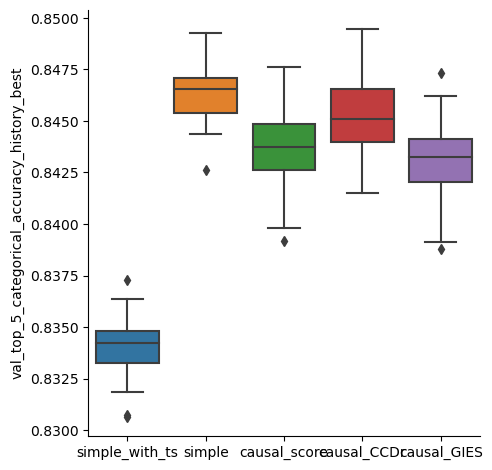

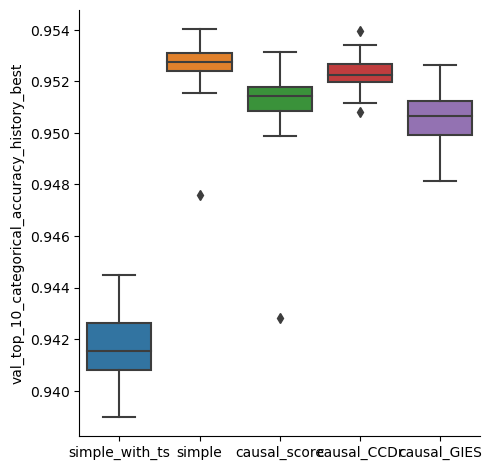

In [39]:
overall_df = run_df.copy()
overall_df.loc[(overall_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False') 
    & (overall_df['data_tags_model_type'] == 'simple'), 'data_tags_model_type'] = 'simple_with_ts'
overall_df = overall_df[(overall_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True') | 
(overall_df['data_tags_model_type'] == 'simple_with_ts')]
plot_best_metric_bar(overall_df, ['val_top_5_categorical_accuracy_history_best', 'val_top_10_categorical_accuracy_history_best'],
x_order = ['simple_with_ts', 'simple', 'causal_score', 'causal_CCDr', 'causal_GIES'])

In [40]:
run_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_score', 'causal_CCDr']))
]
run_df = mlflow_helper.load_best_metrics_for_ids(set(run_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 412/412 [00:57<00:00,  7.11it/s]


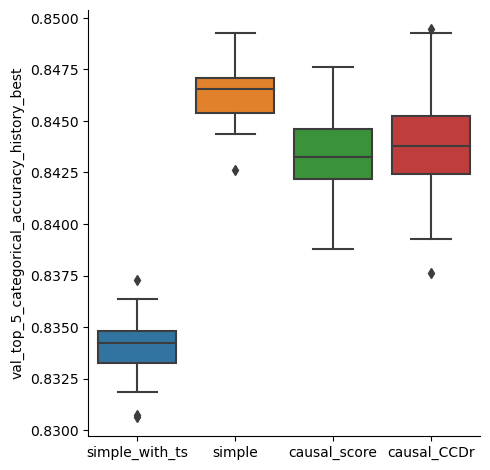

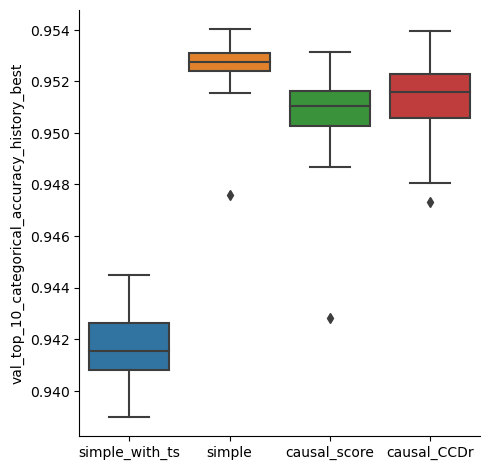

In [41]:
overall_df = run_df.copy()
overall_df.loc[(overall_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False') 
    & (overall_df['data_tags_model_type'] == 'simple'), 'data_tags_model_type'] = 'simple_with_ts'
overall_df = overall_df[(overall_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True') | 
(overall_df['data_tags_model_type'] == 'simple_with_ts')]
plot_best_metric_bar(overall_df, ['val_top_5_categorical_accuracy_history_best', 'val_top_10_categorical_accuracy_history_best'],
x_order = ['simple_with_ts', 'simple', 'causal_score', 'causal_CCDr'])

### Comparing Score Algorithm with Timestamps vs no timestamps

In [42]:
run_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & ((mlflow_helper.run_df['data_tags_model_type'] == 'causal_score')
    | (mlflow_helper.run_df['data_tags_model_type'] == "simple"))
]
run_df = mlflow_helper.load_best_metrics_for_ids(set(run_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 253/253 [00:34<00:00,  7.29it/s]


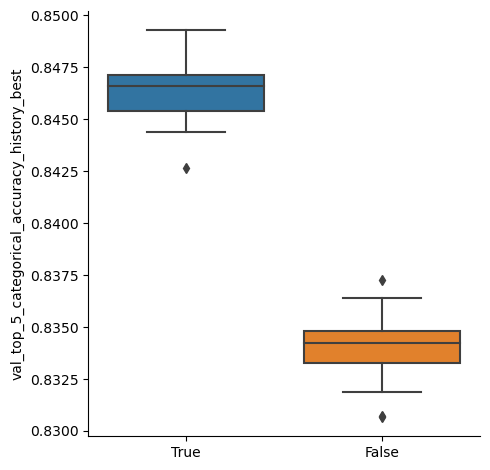

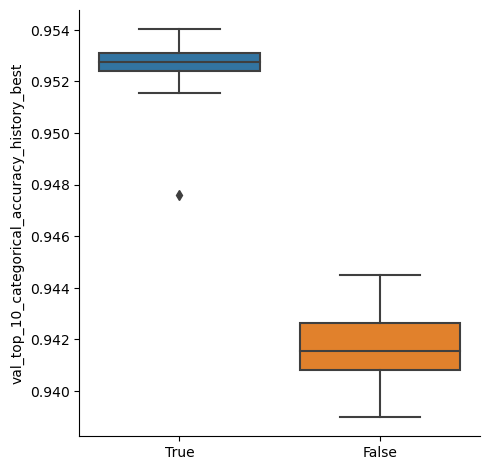

In [43]:
# Simple with timestamp vs no timestamp
simple_df = run_df[run_df['data_tags_model_type'] == 'simple']
plot_best_metric_bar(simple_df, ['val_top_5_categorical_accuracy_history_best', 'val_top_10_categorical_accuracy_history_best'],
    x_feature_name='data_params_HuaweiPreprocessorConfigremove_dates_from_payload',
    x_order=['True', 'False'], # True = no timestamps, False = with timestamps
    titles= "Simple {x_feature_name}"
)

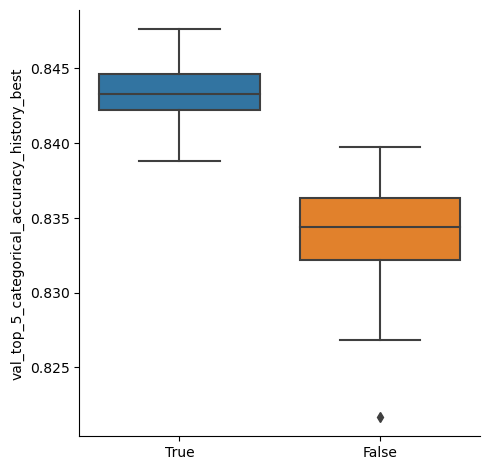

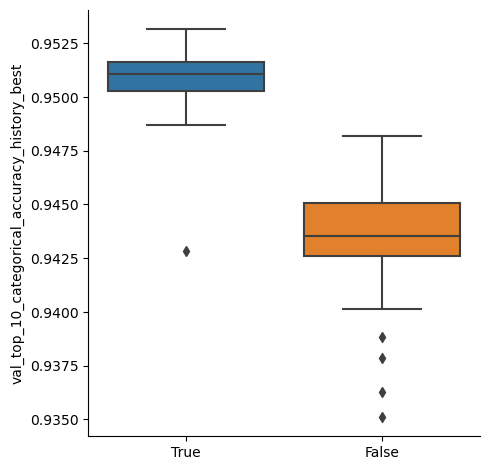

In [44]:
# Score algorithm with timestamp vs no timestamp
score_df = run_df[run_df['data_tags_model_type'] == 'causal_score']
plot_best_metric_bar(score_df, ['val_top_5_categorical_accuracy_history_best', 'val_top_10_categorical_accuracy_history_best'],
    x_feature_name='data_params_HuaweiPreprocessorConfigremove_dates_from_payload',
    x_order=['True', 'False'], # True = no timestamps, False = with timestamps
    titles= "Score algorithm {x_feature_name}"
)

In [45]:
# accuracy_df = calculate_accuracies_per_percentiles(
#    relevant_run_df=run_df, k=5, num_percentiles=10, num_input_percentiles=10,
#    percentile_names=percentile_names,
#    local_mlflow_dir=mlflow_helper.local_mlflow_dir)
accuracy_df = pd.read_csv('/home/i40/almasrirz/Domain-Guided-Monitoring/data/percentile_accuracy_score_simple.csv')

In [46]:
# To get the plot to show, I appended simple results with timestamps not
# removed because my original results had the param set to True. Keeping or
# removing timestamps doesn't matter though for the simple case
relevant_run_df = run_df.copy()
simple_df = relevant_run_df.copy().loc[relevant_run_df['data_tags_model_type'] == 'simple', :]
simple_df.loc[:,'data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] = 'False'
relevant_run_df = pd.concat([relevant_run_df, simple_df])

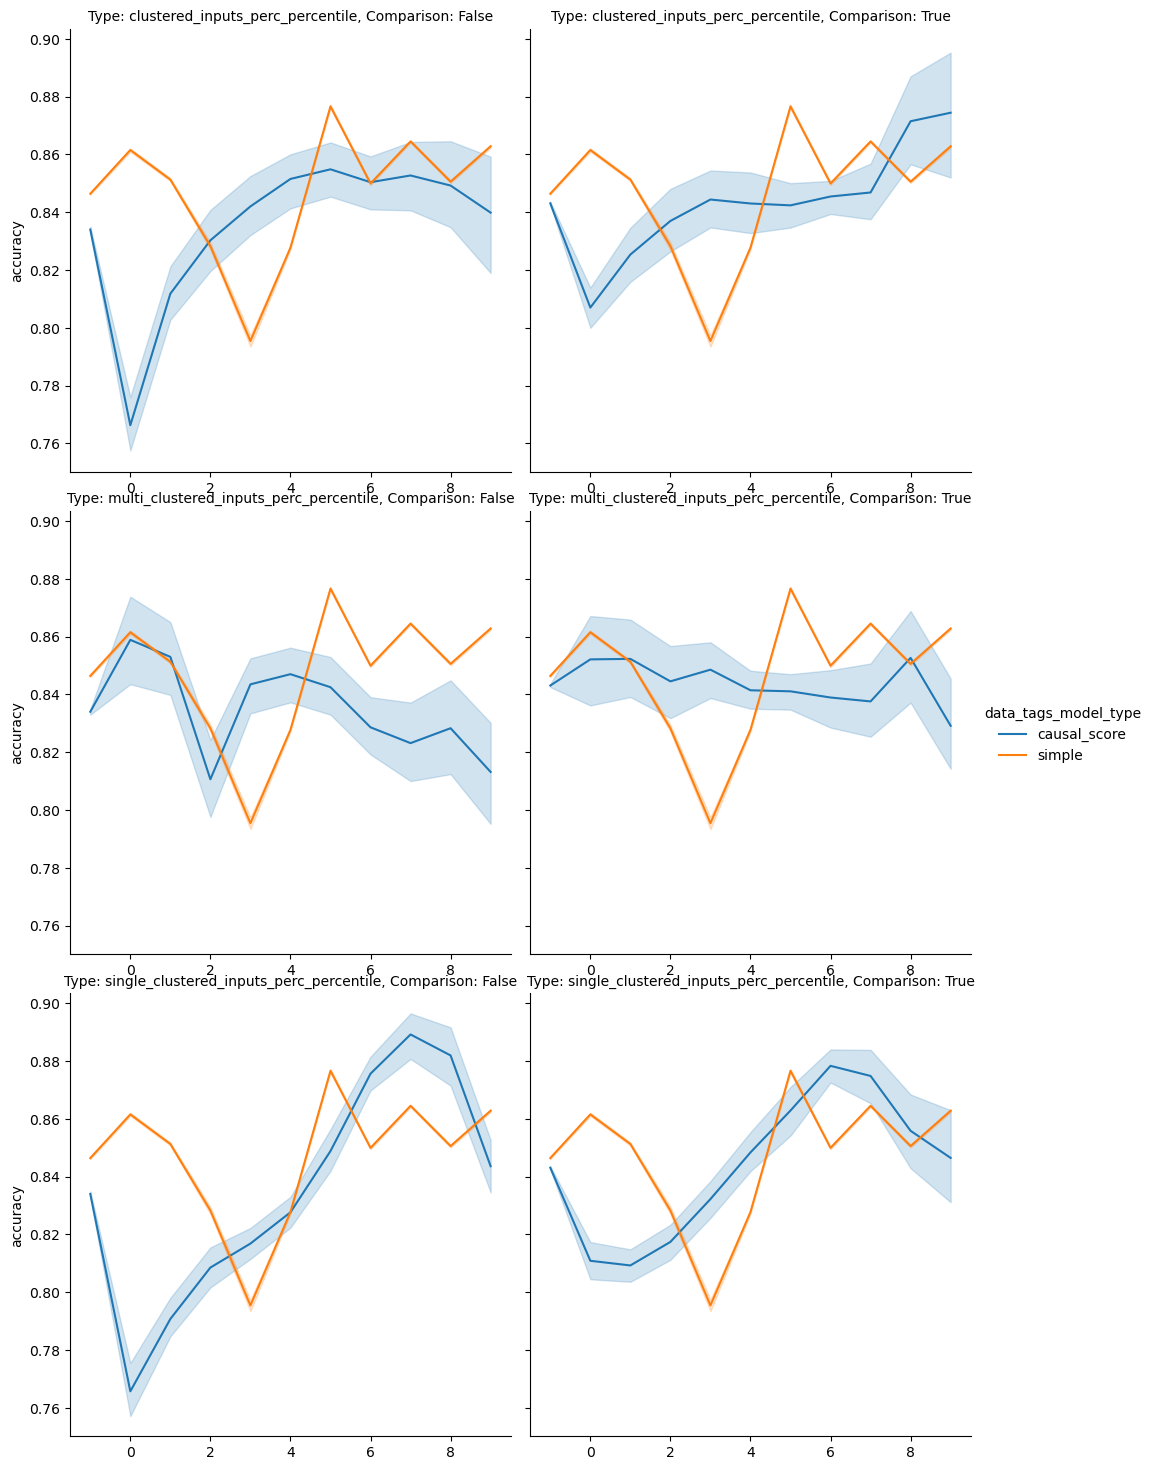

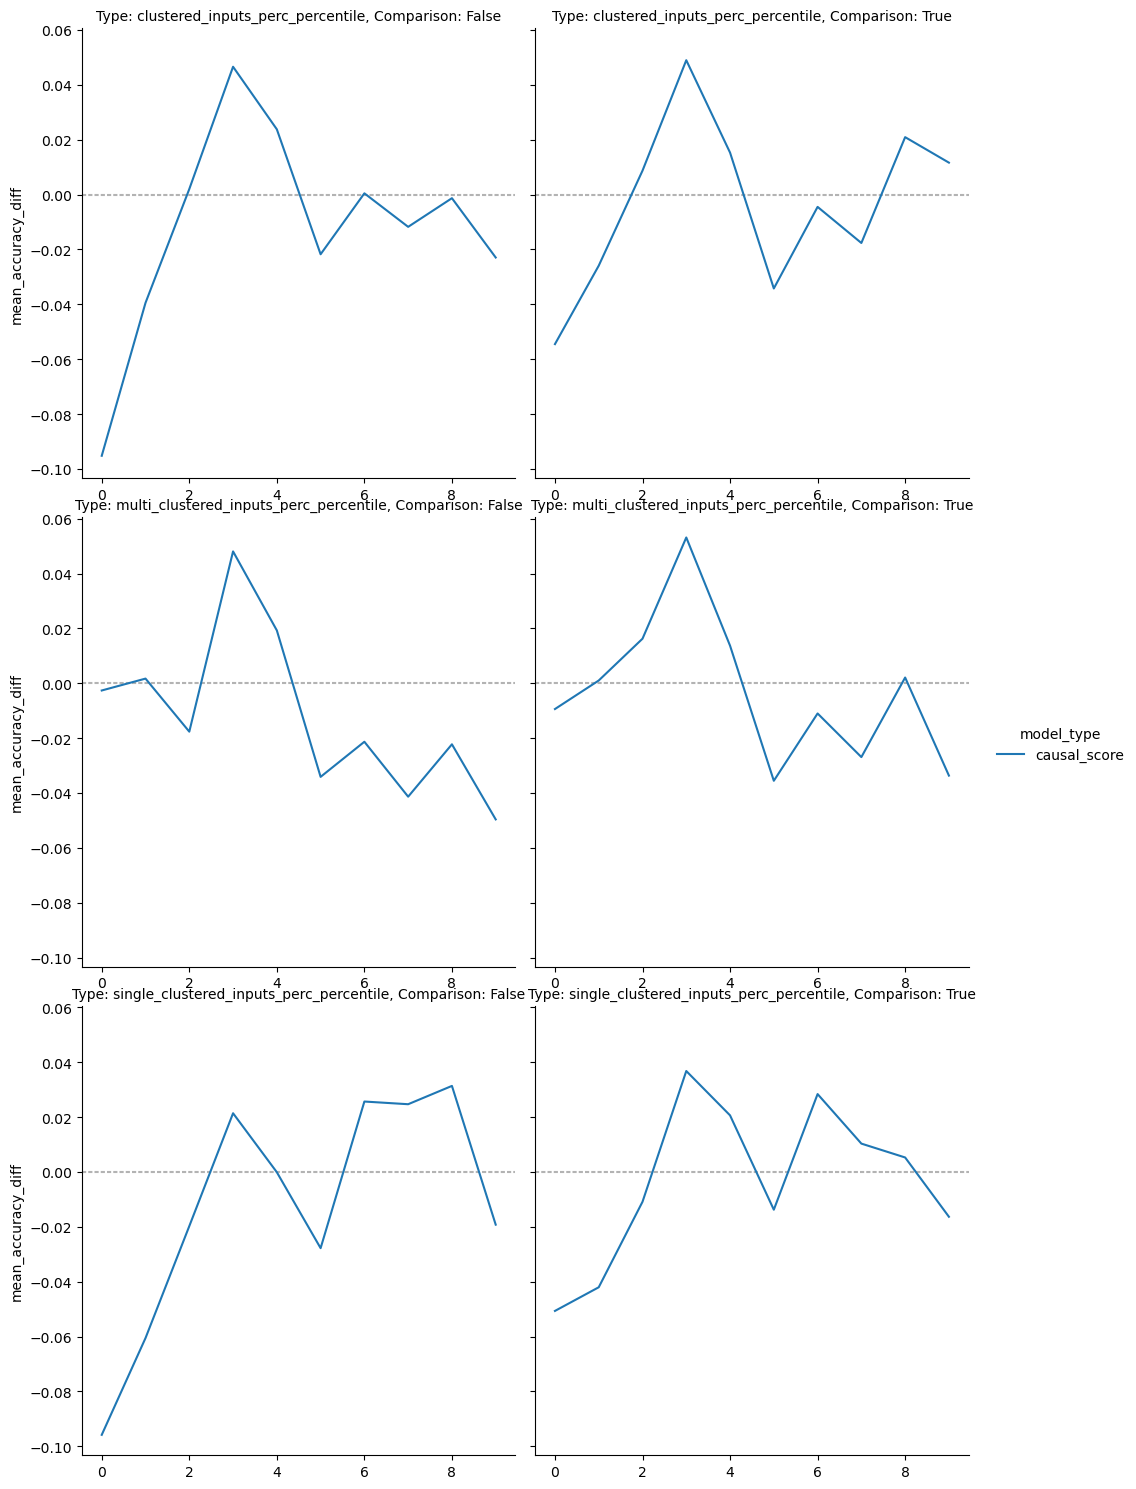

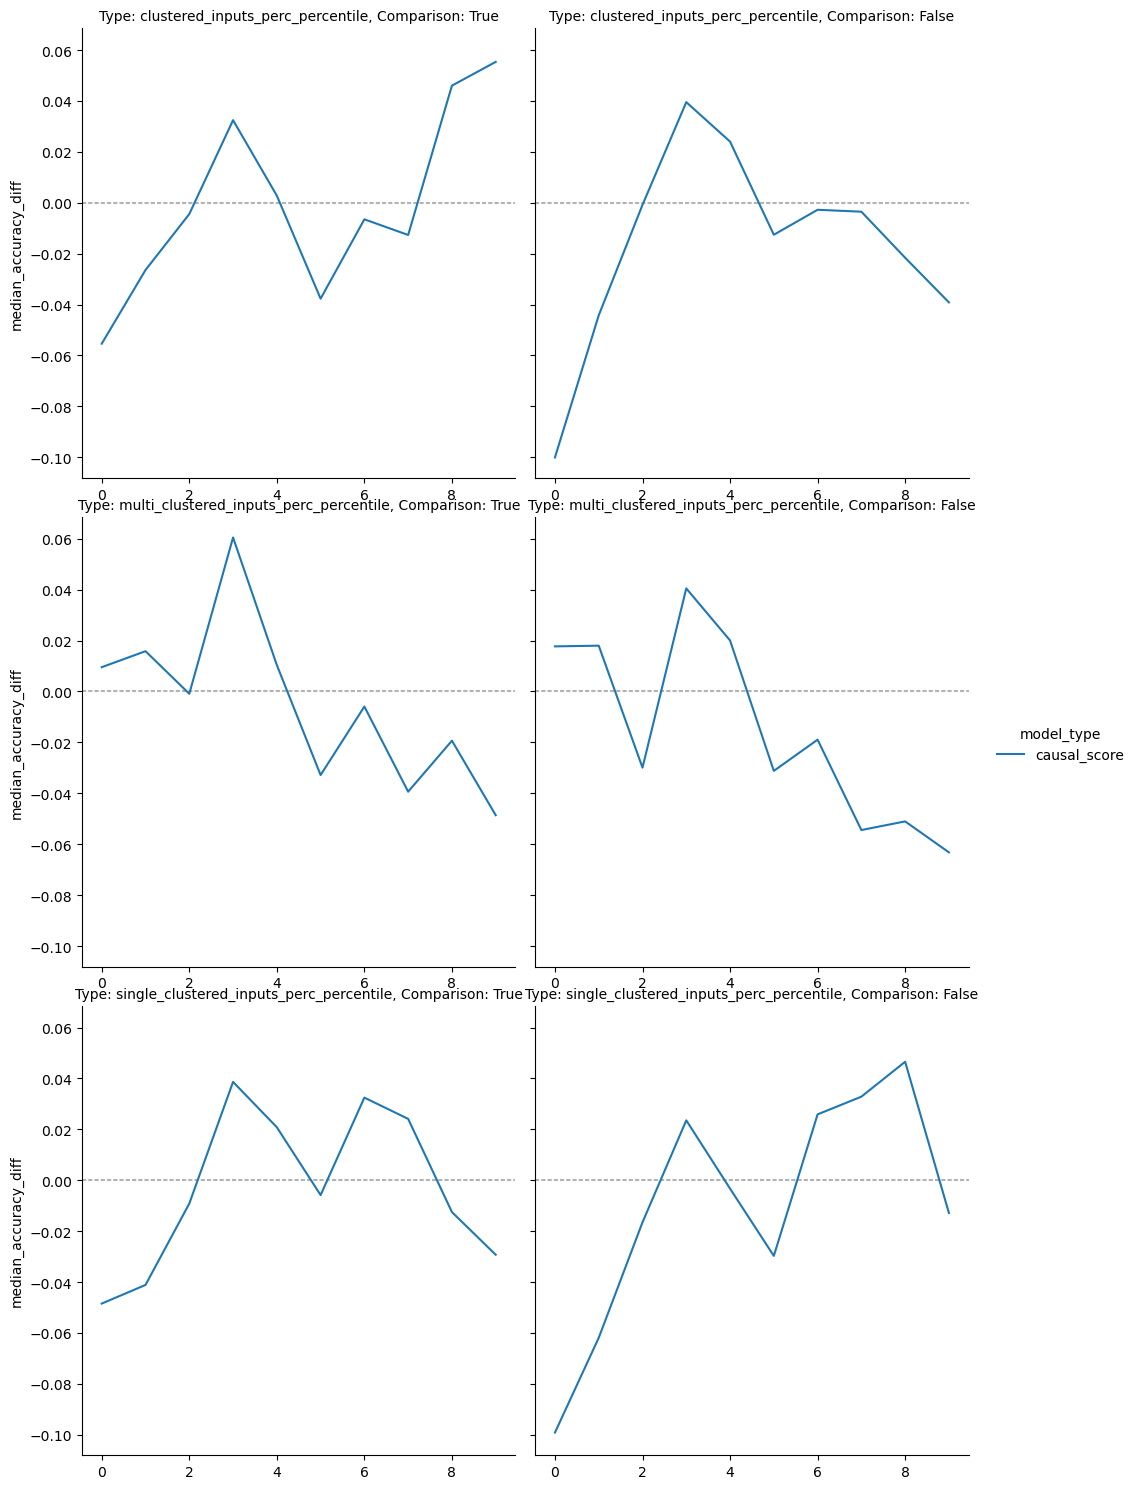

In [47]:
plot_accuracies_per_percentiles(
    relevant_run_df=relevant_run_df, 
    accuracy_df=accuracy_df[
        accuracy_df["type"].apply(lambda x: x in [
            "clustered_inputs_perc_percentile",
            "single_clustered_inputs_perc_percentile",
            "multi_clustered_inputs_perc_percentile"
        ])    
    ],
    show_plot=True,
    share_y=True,
    comparison_column="data_params_HuaweiPreprocessorConfigremove_dates_from_payload",
    algorithm_types=["causal_score"]
)

### CCDr vs Score vs Simple

In [48]:
run_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['causal_score', 'causal_CCDr', 'simple']))
]
run_df = mlflow_helper.load_best_metrics_for_ids(set(run_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 412/412 [00:59<00:00,  6.98it/s]


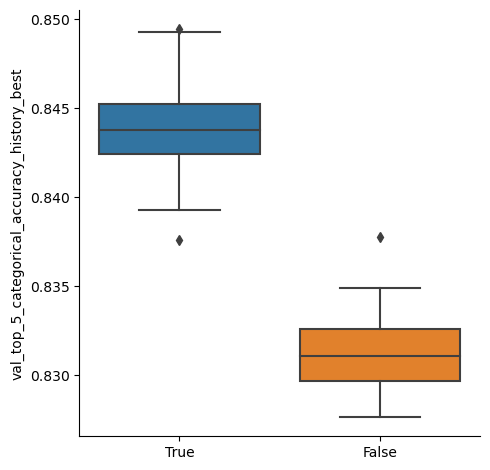

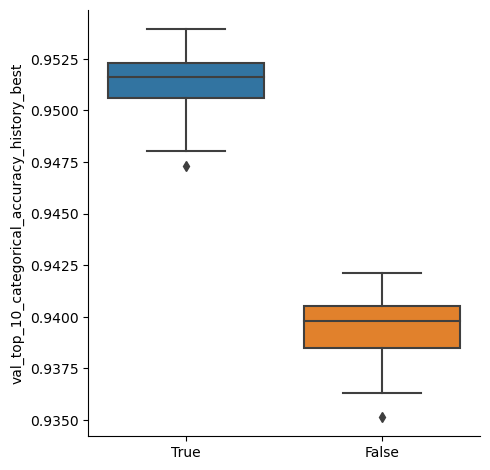

In [49]:
# CCDr algorithm with timestamp vs no timestamp
ccdr_df = run_df[run_df['data_tags_model_type'] == 'causal_CCDr']
plot_best_metric_bar(ccdr_df, ['val_top_5_categorical_accuracy_history_best', 'val_top_10_categorical_accuracy_history_best'],
    x_feature_name='data_params_HuaweiPreprocessorConfigremove_dates_from_payload',
    x_order=['True', 'False'], # True = no timestamps, False = with timestamps
    titles= "CCDr algorithm {x_feature_name}"
)

In [50]:
# accuracy_df = calculate_accuracies_per_percentiles(
#    relevant_run_df=run_df, k=5, num_percentiles=10, num_input_percentiles=10,
#    percentile_names=percentile_names,
#    local_mlflow_dir=mlflow_helper.local_mlflow_dir)
accuracy_df = pd.read_csv('/home/i40/almasrirz/Domain-Guided-Monitoring/data/percentile_accuracy_ccdr_score_simple_ts_nots.csv')

In [51]:
# To get the plot to show, I appended simple results with timestamps not
# removed because my original results had the param set to True. Keeping or
# removing timestamps doesn't matter though for the simple case
relevant_run_df = run_df.copy()
simple_df = relevant_run_df.copy().loc[relevant_run_df['data_tags_model_type'] == 'simple', :]
simple_df.loc[:,'data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] = 'False'
relevant_run_df = pd.concat([relevant_run_df, simple_df])

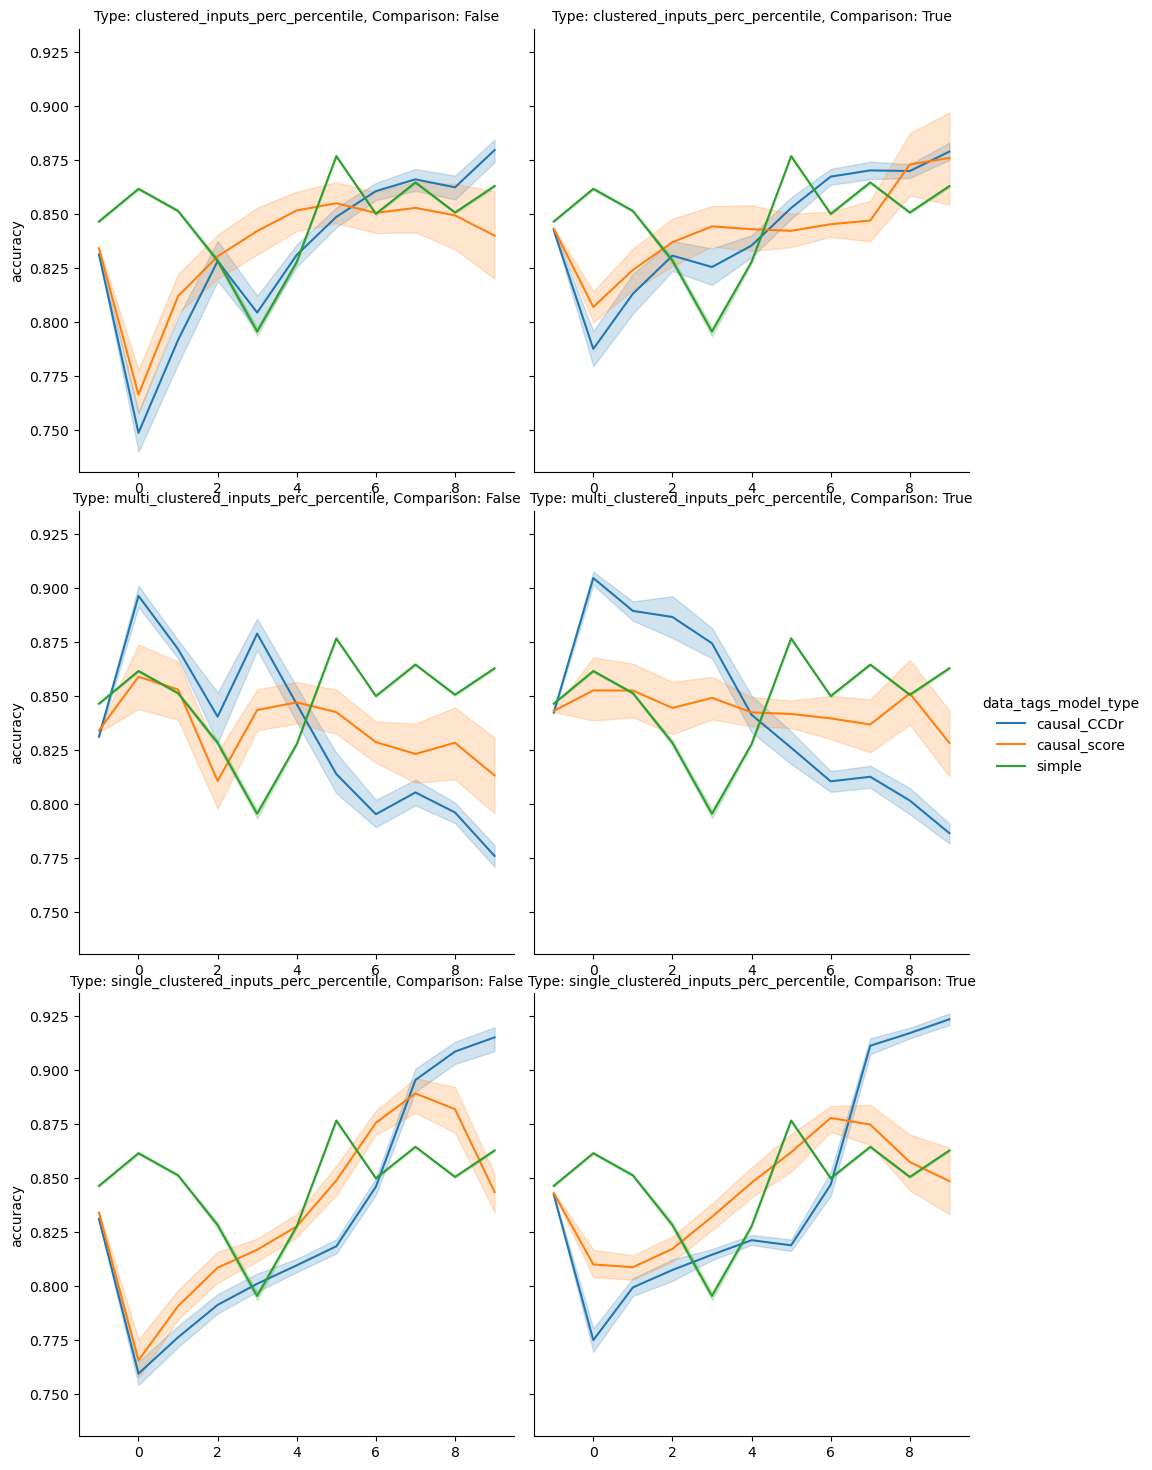

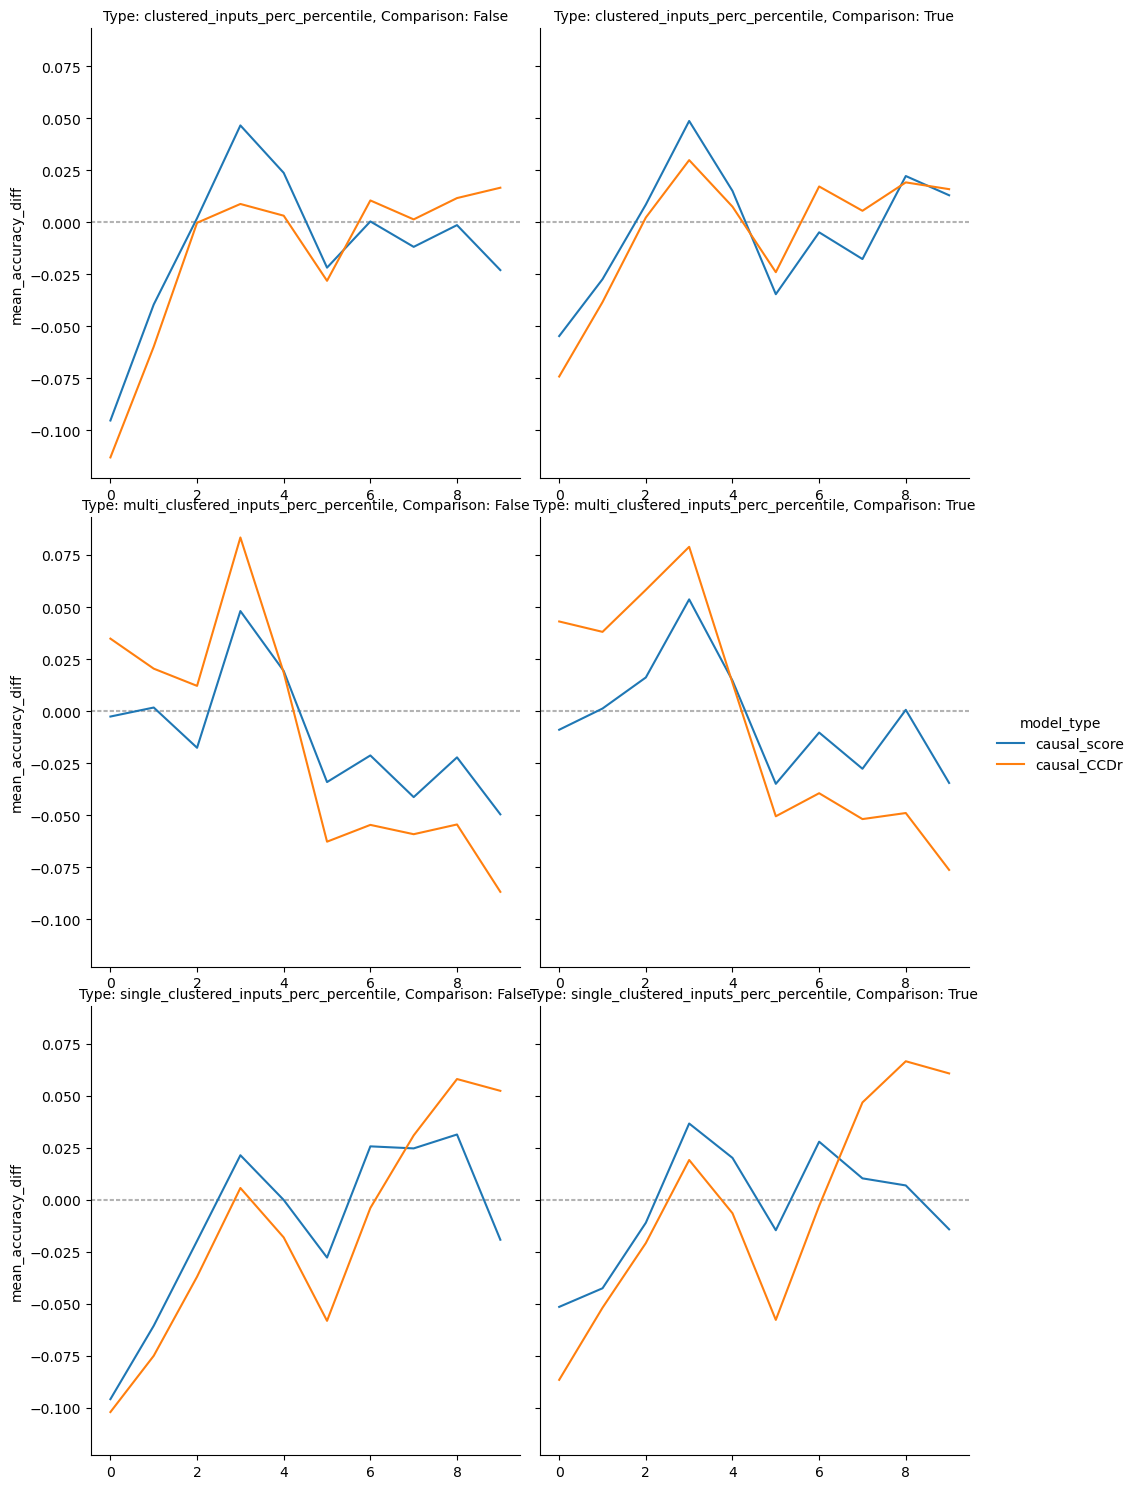

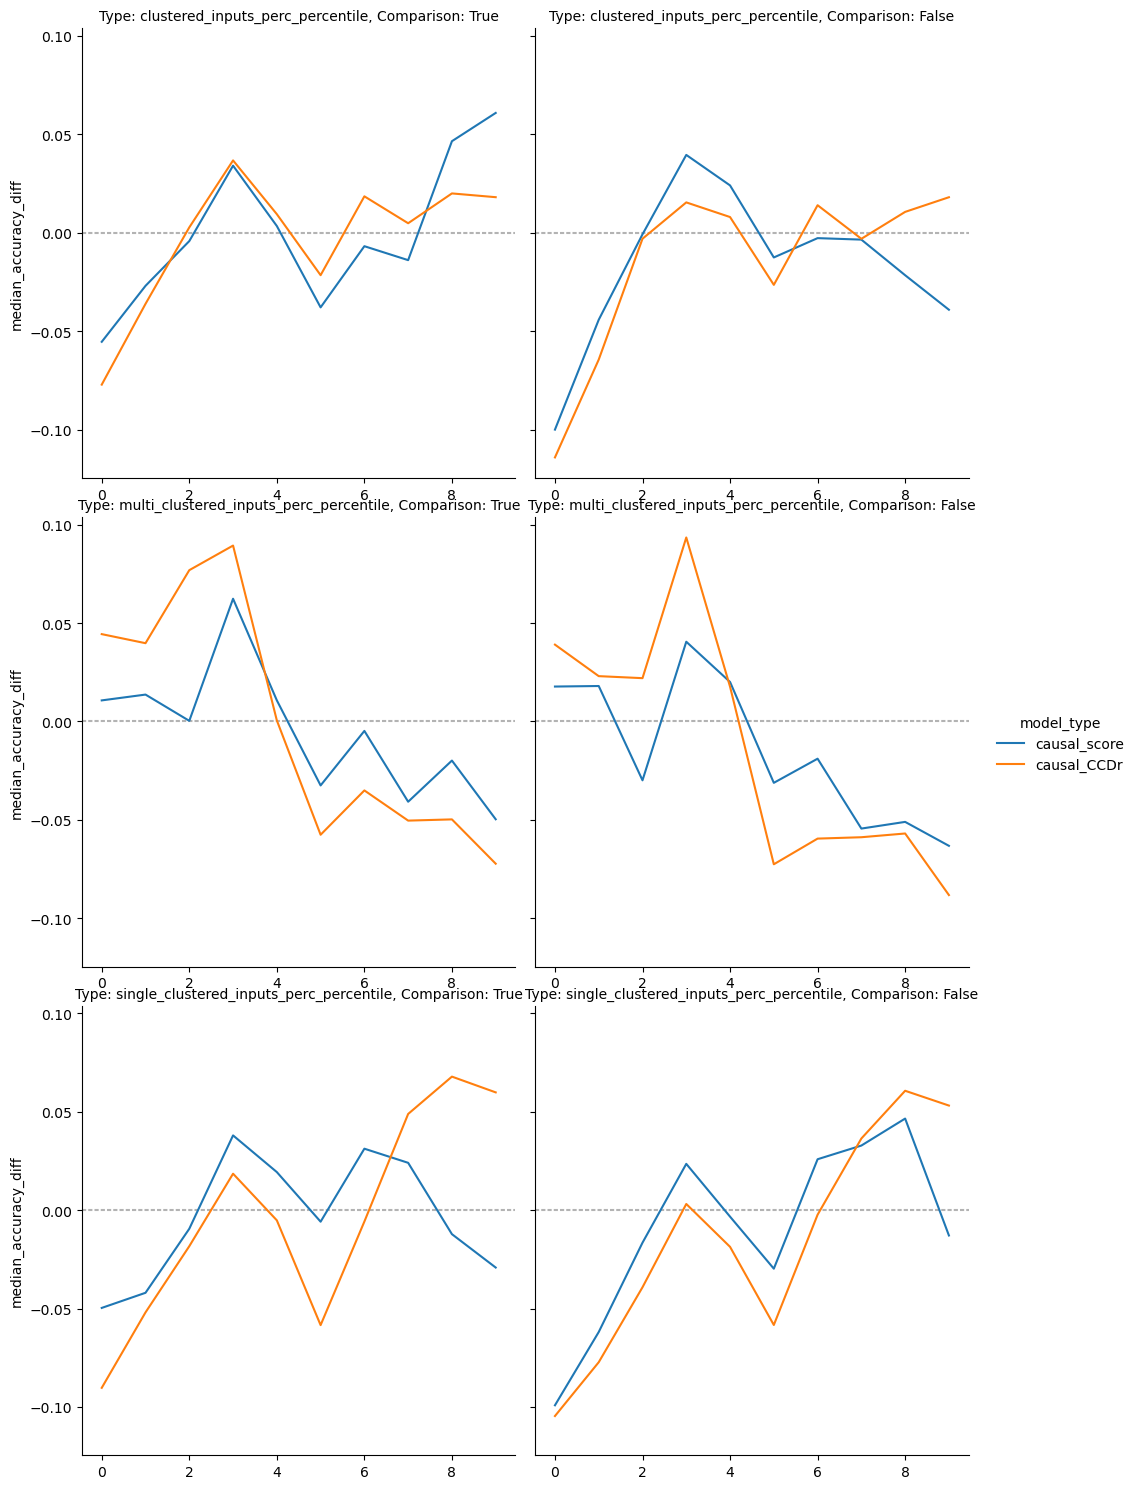

In [52]:
plot_accuracies_per_percentiles(
    relevant_run_df=relevant_run_df, 
    accuracy_df=accuracy_df[
        accuracy_df["type"].apply(lambda x: x in [
            "clustered_inputs_perc_percentile",
            "single_clustered_inputs_perc_percentile",
            "multi_clustered_inputs_perc_percentile"
        ])    
    ],
    show_plot=True,
    share_y=True,
    comparison_column="data_params_HuaweiPreprocessorConfigremove_dates_from_payload",
    algorithm_types=["causal_score", "causal_CCDr"]
)

### Top 5 performing vs simple

In [53]:
run_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & ((mlflow_helper.run_df['data_params_TimeSeriesTransformerConfigbin_overlap'].notnull()) | (mlflow_helper.run_df['data_tags_model_type'] == 'simple'))
]
run_df = mlflow_helper.load_best_metrics_for_ids(set(run_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 767/767 [01:44<00:00,  7.32it/s]


In [54]:
overall_df = run_df.copy()
overall_df.loc[(overall_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False') 
    & (overall_df['data_tags_model_type'] == 'simple'), 'data_tags_model_type'] = 'simple_with_ts'
overall_df = overall_df[(overall_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True') | 
(overall_df['data_tags_model_type'] == 'simple_with_ts')]

In [55]:
top_5_df = pd.DataFrame(overall_df.groupby(['data_tags_model_type'])['val_top_5_categorical_accuracy_history_best'].mean().sort_values(ascending=False))

In [56]:
top_5_df

,val_top_5_categorical_accuracy_history_best
data_tags_model_type,
causal_Fast-IAMB-jt,0.846920
causal_MMPC-cor,0.846664
causal_Fast-IAMB-smc-cor,0.846414
simple,0.846370
causal_MMPC-mi-g,0.846305
causal_GS-smc-mi,0.846221
causal_MMPC-sp-x2,0.846198
causal_GS-smc-zf,0.846139
causal_GS-mc-zf,0.845945


In [57]:
top_5_df = top_5_df.reset_index()

In [69]:
top_5_df.columns

Index(['data_tags_model_type', 'val_top_5_categorical_accuracy_history_best'], dtype='object')

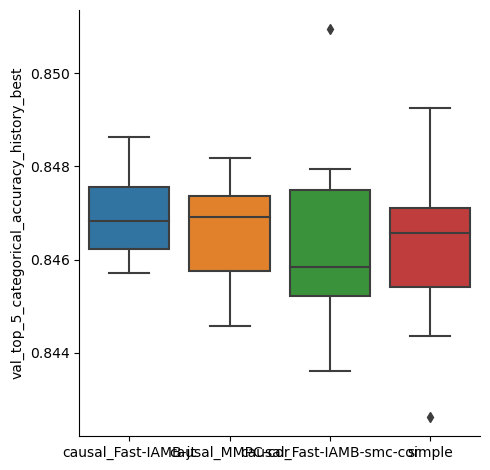

In [73]:
plot_best_metric_bar(overall_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_5_df['data_tags_model_type'].tolist()[:4])

In [74]:
top_10_df = pd.DataFrame(overall_df.groupby(['data_tags_model_type'])['val_top_10_categorical_accuracy_history_best'].mean().sort_values(ascending=False))

In [79]:
top_10_df = top_10_df.reset_index()

In [80]:
top_10_df

,data_tags_model_type,val_top_10_categorical_accuracy_history_best
0,causal_MMPC-smc-cor,0.953044
1,causal_MMPC-mc-jt,0.953001
2,causal_Fast-IAMB-smc-cor,0.952919
3,causal_GS-smc-mi,0.952910
4,causal_MMPC-cor,0.952905
5,causal_MMPC-mi-g,0.952901
6,causal_GS-mc-zf,0.952895
7,causal_MMPC-smc-mi-g,0.952879
8,causal_Fast-IAMB-jt,0.952817
9,causal_MMPC-mi-g-sh,0.952756


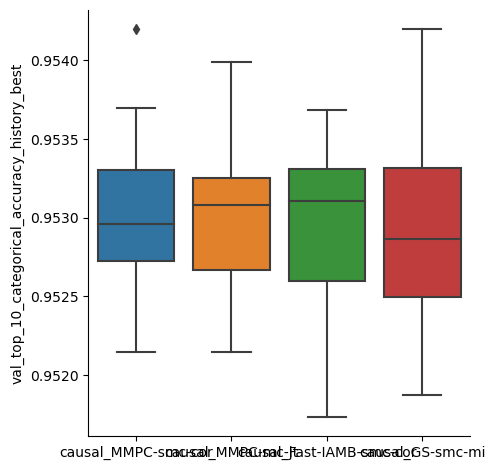

In [81]:
plot_best_metric_bar(overall_df, ['val_top_10_categorical_accuracy_history_best'],
x_order = top_10_df['data_tags_model_type'].tolist()[:4])